# Numerical simulation of the wave equation in 2D using Finite Difference

The simple second-order discretisation approximation we worked out for the 1d wave equation is:

$$\quad u_\xi^{\tau+1}\ \approx \ \frac{\delta t^2c^2_\xi}{\delta x^2}\left(u_{\xi+1}^\tau-2u_\xi^\tau+u_{\xi-1}^\tau\right) + 2u_\xi^\tau - u_\xi^{\tau-1}$$

We used the Taylor series applied along $x$ direction (as well as along time), and truncated at $4^\text{th}$ order terms, to derive the above discretisation (in both time & space), which ends up accurate to 2nd-order:.

The spatial part of the discretisation combined these two Taylor series expansions:

$$f(x_0+\delta x) = f(x_0)+{\frac {f'(x_0)}{1!}}\delta x+{\frac {f''(x_0)}{2!}}\delta x^{2}+{\frac {f'''(x_0)}{3!}}\delta x^{3}+O(\delta x^4)$$

$$f(x_0-\delta x) = f(x_0)-{\frac {f'(x_0)}{1!}}\delta x+{\frac {f''(x_0)}{2!}}\delta x^{2}-{\frac {f'''(x_0)}{3!}}\delta x^{3}+O(\delta x^4)$$

$$\text{Leading to:}\quad f''(x_0) = \frac{f(x_0+\delta x) + f(x_0-\delta x) - 2f(x_0)}{\delta x^2} + O(\delta x^2)$$

The time-discretised wave equation in 2d (for $x$ and $z$ dimensions) is:

$$u^{\tau+1}(x,z)\ \approx \ \delta t^2c(x,z)^2\ 
\left(\frac{\partial^2 u^\tau(x,z)}{\partial x^2}+\frac{\partial^2 u^\tau(x,z)}{\partial z^2}\right)+\ u^\tau(x,z)\ -\ u^{\tau-1}(x,z)$$

>**Task 1:**
>
>**Work through the spatial discretisation again, but this time for the wave equation in 2d**  
>– Note: use pairs of Taylor series as before above, but applied in each direction (i.e. along $x$ and along $z$).
>
>**You should now have a discretisation for the 2d wave equation that you can use for modelling wave propagation in 2d within this notebook (see task 2...)**

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import sys

----

## Create domain model properties (i.e. speed of waves), and discretisation grid

In [2]:
# 500 gridpoints along the x-axis, 350 along the z-axis
nx = 500
nz = 350

# start with homogeneous model - same wave-speed everywhere.
c = np.full((nx,nz),1500.0)  # Note: 1500m/s is typical acoustic velocity of water

In [20]:
length = 3500.0 # assign a length to the model in metres

dx = length/nx # calculate the spatial increment between model parameters

depth = dx*nz # calculate the depth from the length and number of x and z gridpoints

print('Domain is %d x %d grid-cells (%.1fm x %.1fm)' % (nx,nz,length,depth))
print('Grid-spacing (dx) is %.2fm' % (dx))

In [21]:
plt.figure(figsize=(10,6))
plt.imshow(c.T) # plotting the velocity model (note transposed, to orient plot in way we expect)
plt.colorbar()
plt.xlabel('x gridpoints')
plt.ylabel('z gridpoints')
plt.title('Velocity Model (m/s)')
plt.show()

----
## Modelling constraints
#### CFL stability condition should be satisfied – the 'Courant number'.

The dimensionless Courant number, $C$, gives a measure of how far a signal will travel across a grid-cell (/between grid-points) within one time-step.
(Hence why I will very often refer to it as 'the crossing factor'.)

The crossing factor is $c$.$\delta t$/$\delta x$ for speed $c$, and we want the maximum value of this within the whole domain to satisfy some constraint that depends upon the finite-difference stencil(s) in use when modelling.

i.e. we want:$\quad \text{max}(c)$.$\delta t/\delta x <= C_{max}$, where $\ C_{max}$ depends on the discretisations.

We can turn this around to find the maximum time-step for our model and grid-spacing, given $C_{max}$ for our discretisations:

$$\delta t_{best} = \frac{C_{max}\ \delta x}{\text{max}(c)}$$

#### This spatial stencil (simple 2nd order), with 2nd-order time-stepping, requires the max crossing factor to (usually) be no more than ~sqrt(2)
(i.e. can only cross up to 70.7% of a cell in one time-step – we'll use 70% here...)

In [6]:
courant = 0.70  # set the dimensionless max Courant number for 2nd-order FD grid in space & time

In [7]:
time = 2.0  # desired length of the simulation in seconds
dt = (courant*dx)/c.max()  # define the best time-step by using the max Courant number
nt = int(time/dt+0.9999)  # how many steps are needed to cover that time
time = nt*dt  # turn that back into exact time for this number of steps
print('Time-step = %.5fs  Number of steps = %d  (Total time being modelled: %.5fs)' % (dt,nt,dt*nt))

Time-step = 0.00327s  Number of steps = 613  (Total time being modelled: 2.00247s)


### Create source function (Ricker wavelet with 8Hz peak frequency)

In [15]:
# want to locate the source in the grid
sx = 150
sz = 80

The Ricker wavelet used here is a function of time that's defined from the second derivate of a Gaussian function (which is $G(t)=\text{e}^{-a^2 t^2}$).

–It's also known as the Mexican hat wavelet, due to its shape when plotted as a function of two variables.

It can be written so it is symmetric about time zero, with maximum at that time, ultimately decaying towards zero as $t$$\rightarrow$$±\infty$. However, we will shift it in time so that it starts near zero at our time zero.

After differentiating above Gaussian, $G(t)$, twice, flipping, then scaling (and before shifting in time), we get: $\quad R(t) = (1-2a^2 t^2)\ \text{e}^{-a^2 t^2}$

The peak frequency of the Ricker wavelet is at $f$=$a/\pi$.

The length of the wavelet, in time, before it decays close enough to zero for our purposes, is about $\frac{2.1}{f}$ (i.e. about $\frac{1.05}{f}$ seconds each side of the wavelet's central peak).

In [10]:
amp = 1.0  # amplitude of the source wavelet 
freq = 8.0  # peak frequency of source wavelet
ts = 2.1/freq  # desired length of wavelet in time is related to peak frequency
ns = int(ts/dt+0.9999)  # figure out how many time-steps are needed to cover that time
ts = ns*dt  # and now turn that back into a time that's exactly the required number of steps
print('Length of wavelet will be %.5f secs (%d steps)' % (ts,ns))

Length of wavelet will be 0.26460 secs (81 steps)


In [11]:
a2 = (freq*np.pi)**2  # a squared (see equation above)
t0 = ts/2 - dt/2  # midpoint time of wavelet
src = np.zeros(ns)
# create Ricker wavelet (see equation above), offset by time t0 (so midpoint of wavelet is at time t=t0)
for i in range(ns):
    src[i] = amp*( (1 - 2*a2*((i*dt-t0)**2)) * np.exp(-a2*((i*dt-t0)**2)) )
    #src[i] = amp*np.sin((0.5+i)*np.pi/ns)**2  # uncomment to make sine-squared 'bump' instead (not 7Hz peak tho')
print('Endpoint values are: %.6f %.6f' % (src[0],src[-1]))

Endpoint values are: -0.000426 -0.000426


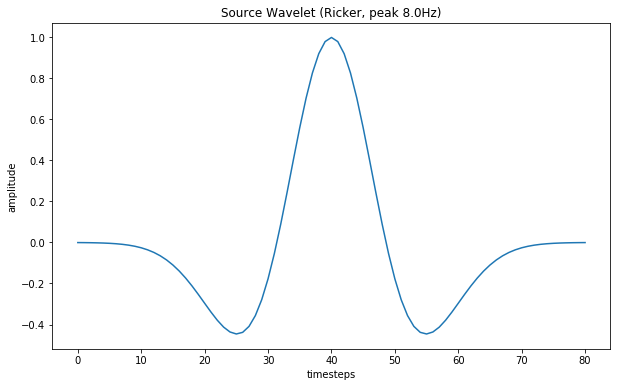

In [12]:
plt.figure(figsize=(10,6))
plt.plot(src) # plot source wavelet
plt.xlabel('timesteps')
plt.ylabel('amplitude')
plt.title('Source Wavelet (Ricker, peak %.1fHz)' % (freq))
plt.show()

### Check that the maximum frequency in the source wavelet can propagate reliably

For a simple second-order finite-difference, the minimum wavelength of a signal that we can propagate reliably is about 10 cells.

In [13]:
min_cells_per_wl = 10.0  # minimum of 10 cells per wavelength for reasonably accurate propagation
max_freq = c.min()/(min_cells_per_wl*dx) # calculate the max frequency that can be modelled without numerical dispersion
print('Maximum reliable propagation frequency is about %.1fHz' % max_freq)

Maximum reliable propagation frequency is about 21.4Hz


#### Want to avoid causing too much dispersion by keeping maximum significant frequency within this limit...

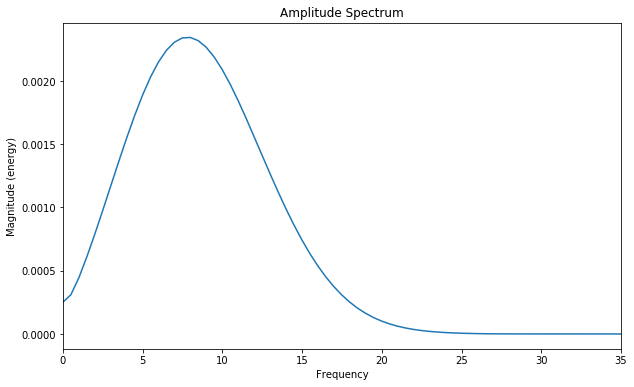

In [14]:
# plot amplitude spectrum of source wavelet
plt.figure(figsize=(10,6))
plt.magnitude_spectrum(np.append(src,np.zeros(nt-ns)), Fs=1/dt)  # note padding to nt points
plt.title('Amplitude Spectrum')
plt.xlim(0,35)
plt.show()

## Line of receivers within domain
–To detect what crosses a particular horizontal line of the domain (i.e. constant depth) over time

>**Task 3:** $\quad$ *(Yes... task 2 is further down – complete that before this!)*
>
>**In the cell below, create a 2d array `r` that will keep a record over time of the wavefield that passes through all the gridpoints in a horizontal line that crosses at about 70 gridpoints down the domain (which is a little above the source point, since we had `sz=80` earlier).**
>
>**In the main time-stepping loop further down, add code to record the wavefield at each time-step.**
>
>**Once you have done this, and have run the simulation, the code cell that is designed to "Plot data at receivers" (after the wavefield plots at different times), should then show a figure with the response over time across this line of receivers.**

In [16]:
# FILL IN CODE HERE TO BUILD EVERYTHING FOR RECEIVER ARRAY...




----
# Simulation

In [26]:
# Initialise arrays for wavefields
u = np.zeros((nx,nz)) # current wavefield
u_prv = np.zeros((nx,nz)) # old t-1 wavefield
u_nxt = np.zeros((nx,nz)) # new t+1 wavefield

In [27]:
# prepare an array to store wavefield snapshots for plotting
sampling_rate = 10 # set sampling rate used to store wavefield (every 10 timesteps)
wavefield = np.zeros((int(nt/sampling_rate), nx, nz)) # array to store wavefields every 10 timesteps
print('Storing %d wavefields (every %dth out of %d)' % (wavefield.shape[0],sampling_rate,nt))

Storing 61 wavefields (every 10th out of 613)


In [28]:
# a useful variable – shorthand for something that appears regularly in expressions below
dtdx2 = (dt*dt)/(dx*dx)

>**Task 2:**
>
>**From the discretisation you've just developed in task 1 (at the top of this notebook), write code below (as indicated within the time loop) to fill in the new wavefield during the time-step.**
>
>**– Use the 3 arrays, `u_prv`, `u` & `u_nxt` (that were initialised to zero above) for the 3 time positions, $\tau\text{-1}$, $\tau$ and $\tau\text{+1}$.**  

In [31]:
u[sx,sz] = src[0]  # inject first source entry into current wavefield

# begin time-stepping loop...

for i in range(nt):

    if i%20==0:
        sys.stdout.write('Done step %d (of %d)\r' % (i+1,nt))

    # FILL IN CODE HERE TO CALCULATE THE NEW WAVEFIELD u_nxt...
    
    
    
    
    
    
    
    # inject source entry for this step at the source point
    if i+1<ns:
        u_nxt[sx,sz] = src[i+1]
    
    # shift wavefields for next time-step
    u_prv[:,:] = u[:,:]
    u[:,:] = u_nxt[:,:]
    
    # ADD CODE HERE TO PLACE WAVEFIELD VALUES ALONG RECEIVER LINE INTO ARRAY r
    
    
    
    
    if (i+1)%sampling_rate == 0: # store the current wavefield u on every tenth step
        wavefield[int((i+1)/sampling_rate-1)] = u[:,:]

print('Finished %d time-steps' % (nt))

## Plot wavefield at different times

In [32]:
b=0.06 # bounds for plots will be -b to +b
plot_time = 0.7  # 0.7 seconds
plt.figure(figsize=(10,7))
plt.imshow(wavefield[int(plot_time/(dt*sampling_rate))].T,   # note the wavefield was transposed
           vmin=-b, vmax=b, cmap='RdBu', interpolation='bilinear')
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.colorbar()
plt.xlabel('x gridpoints')
plt.ylabel('z gridpoints')
plt.show()

In [33]:
plot_time = 1.3  # 1.3 seconds
plt.figure(figsize=(10,7))
plt.imshow(wavefield[int(plot_time/(dt*sampling_rate))].T, vmin=-b, vmax=b, cmap='RdBu', interpolation='bilinear')
plt.title('Wavefield at about %.2fs' % (plot_time))
plt.colorbar()
plt.xlabel('x gridpoints')
plt.ylabel('z gridpoints')
plt.show()

## Plot data at receivers

**NOTE: *the code cell below will not work until you have completed task 3*...**

Also, the figure orientation will depend which way around you defined your `r` array in task 2 – if the orientation does not match the axis descriptions, remove the transpose operation (i.e. change `r.T` below to just `r`).

In [24]:
plt.figure(figsize=(10,7))
plt.imshow(r.T, cmap='RdBu', interpolation='bilinear', aspect='auto', 
           vmin=-b*0.6, vmax=b*0.6,   # set bounds for colourmap data
           extent=(0,nx,time,0))  # set bounds for axes
plt.title('Receiver Data')
plt.colorbar()
plt.xlabel('Receiver number')
plt.ylabel('Time / s')
plt.show()

## Make a movie! 

In [34]:
#plt.ioff()
fig = plt.figure(figsize=(10,8))

plt.title('Wavefield')
plt.xlabel('x gridpoints')
plt.ylabel('z gridpoints')

n = wavefield.shape[0]
imgs = []
for i in range(n):
    if i%20==0:  # show progress every 20 frames
        sys.stdout.write('Done %d of %d\r' % (i+1,n))
    img = plt.imshow(wavefield[i].T, vmin=-b, vmax=b, cmap='RdBu', animated=True, interpolation='bilinear')
    imgs.append([img])

print('Finished plots for frames, building animation...')

ani = anim.ArtistAnimation(fig, imgs, interval=50, blit=True)

plt.close(fig)  # prevent final frame plot from showing up inline just below

print('Preparing HTML (takes a little while...)')

HTML(ani.to_jshtml())